# Импорт библиотек и функций

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import random
import os

# Определение возраста покупателей

# Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


- датасет соответстует описанию проекта
- выборка небольшая (7591 изображений), рекомендуется для увелечиния выборки использовать аугментацию

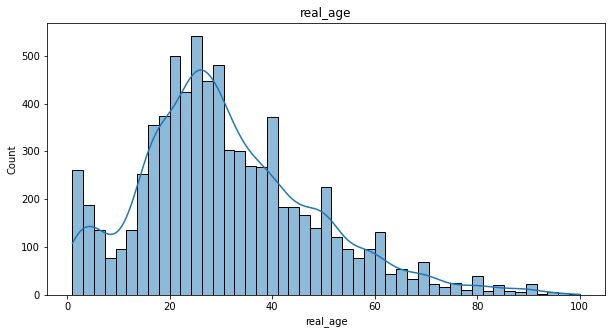

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]
sns.histplot(labels['real_age'], kde=True).set_title('real_age');

- выборка несбалансированная, большье всего фотограий людей до 30 лет, модель наилучше будет справляться именно с этой возрастной группой

In [ ]:
datagen = ImageDataGenerator()
datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


- нет пропусков в списке фотогрфий
- все фотографии имеют нужное расширение и могут использоваться в обучении модели

Printing image with dimensions 787x787


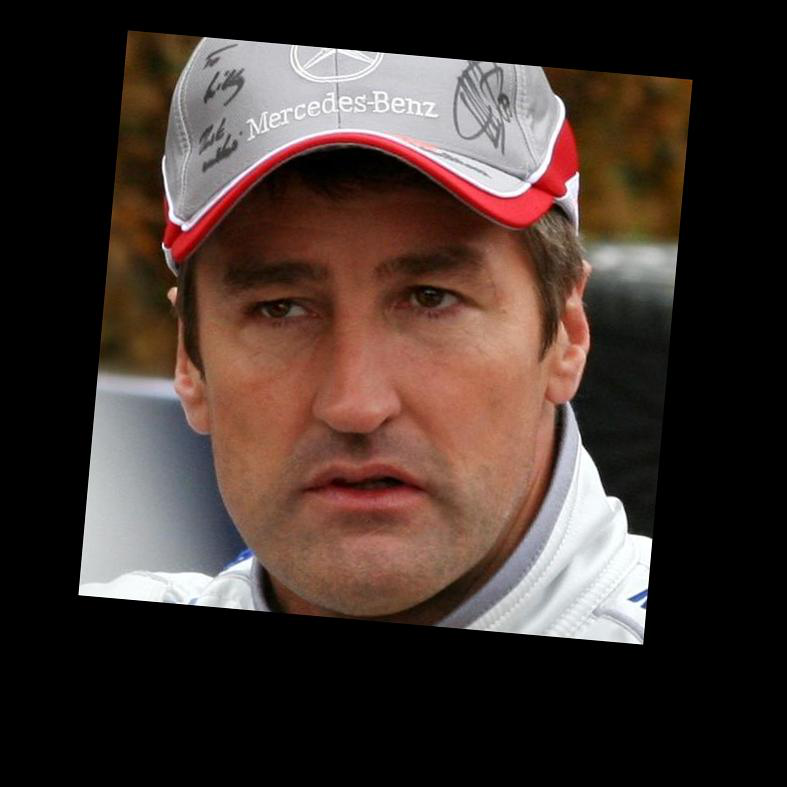

Printing image with dimensions 462x462


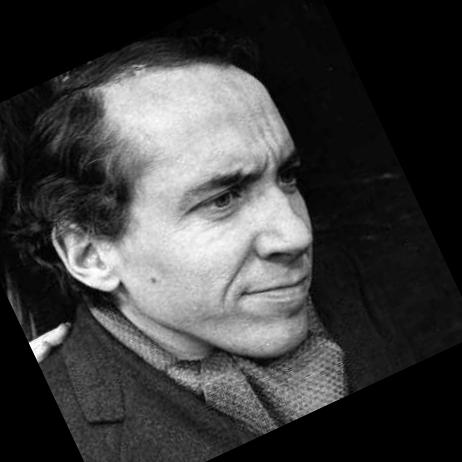

Printing image with dimensions 142x142


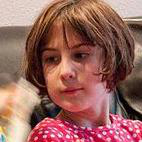

Printing image with dimensions 669x669


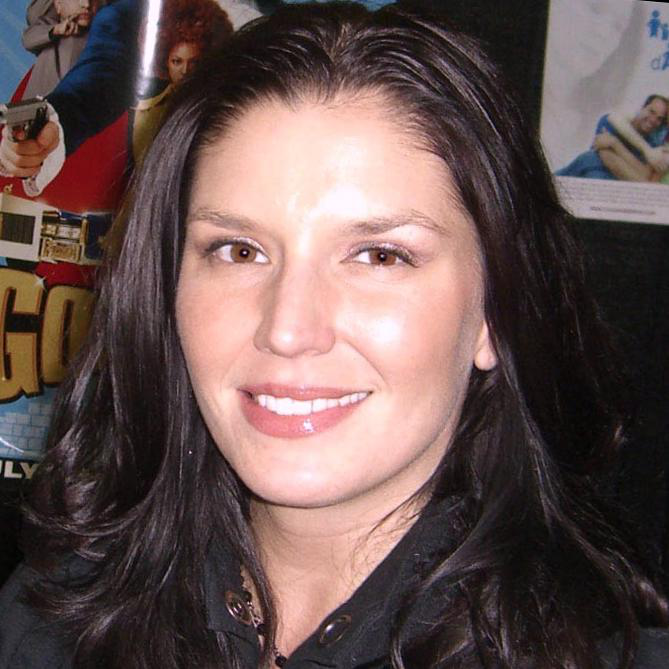

Printing image with dimensions 1035x1035


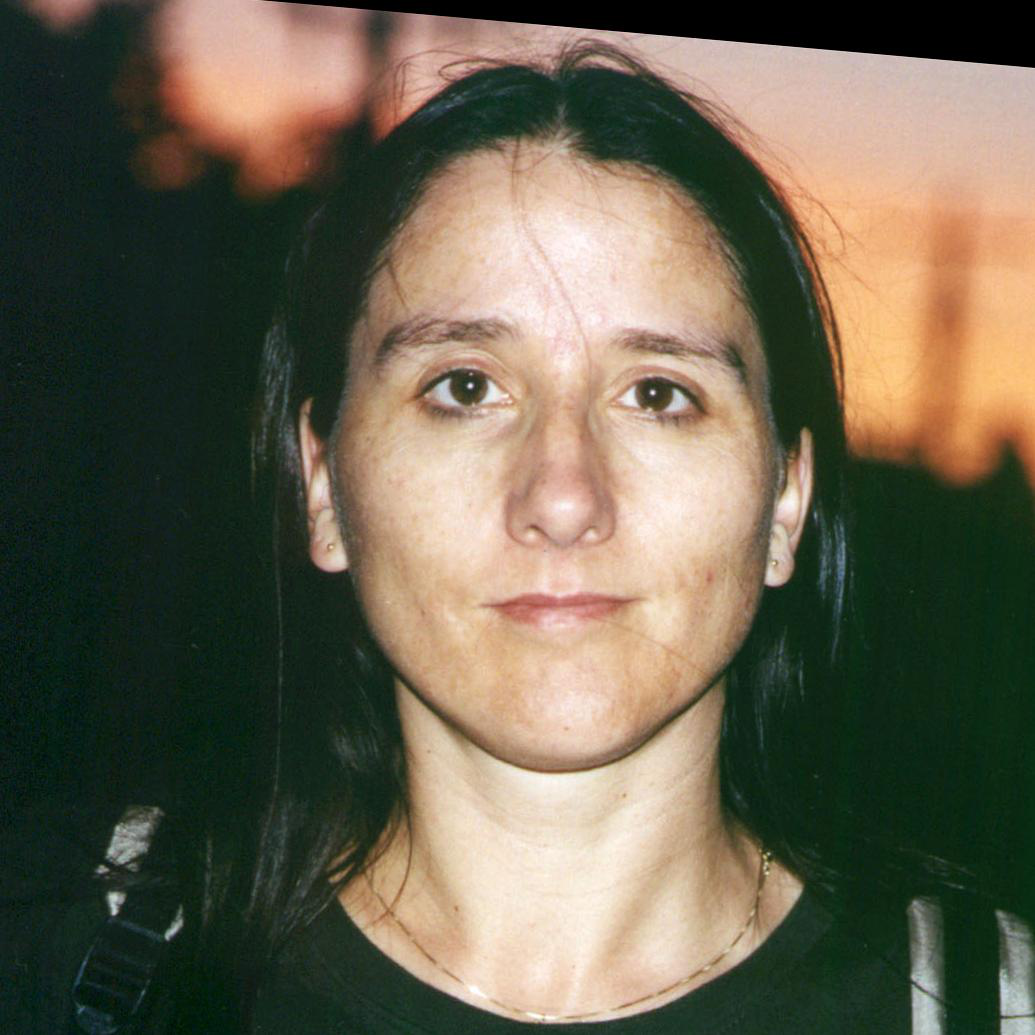

Printing image with dimensions 630x630


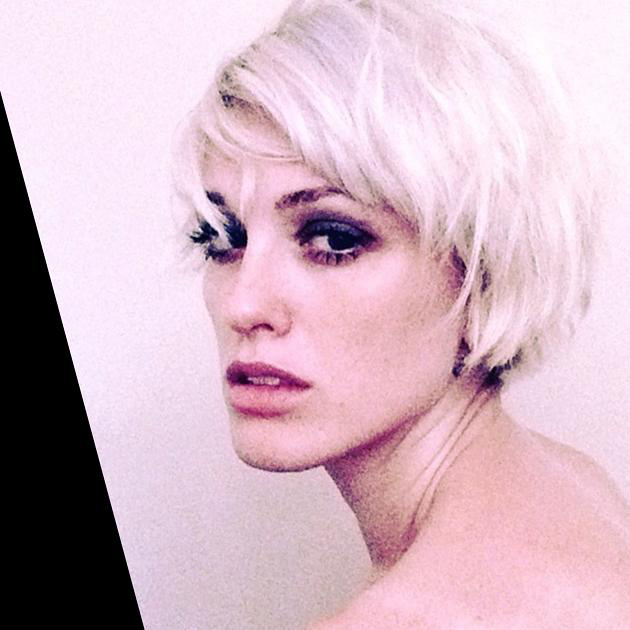

Printing image with dimensions 318x317


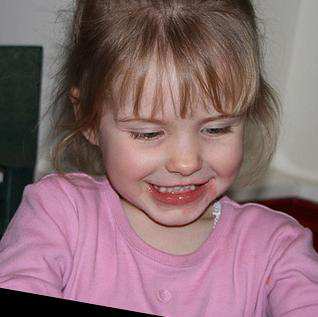

Printing image with dimensions 747x747


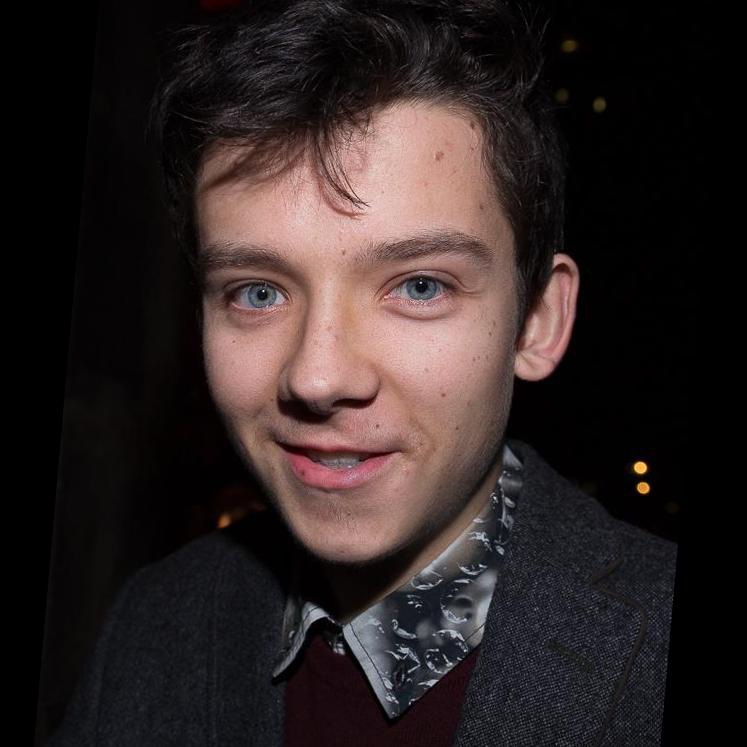

Printing image with dimensions 632x632


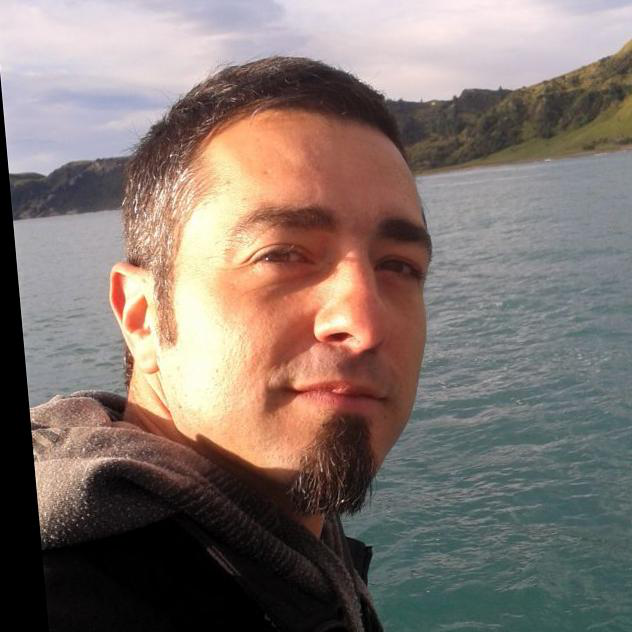

Printing image with dimensions 350x350


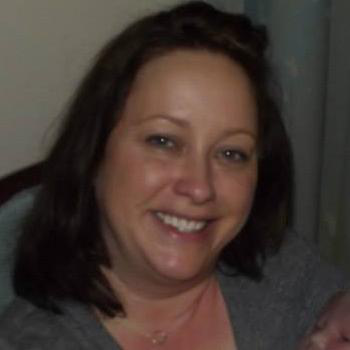

Printing image with dimensions 554x554


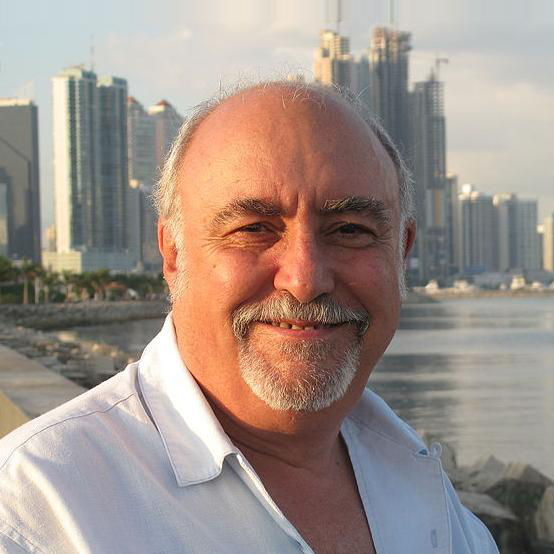

Printing image with dimensions 311x311


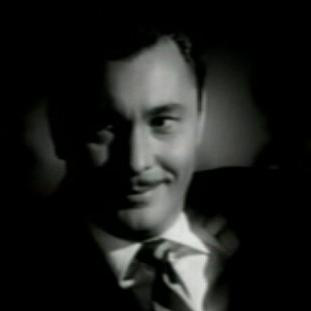

Printing image with dimensions 355x355


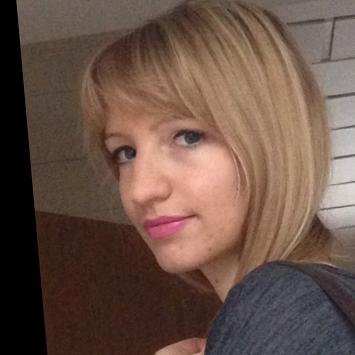

Printing image with dimensions 430x431


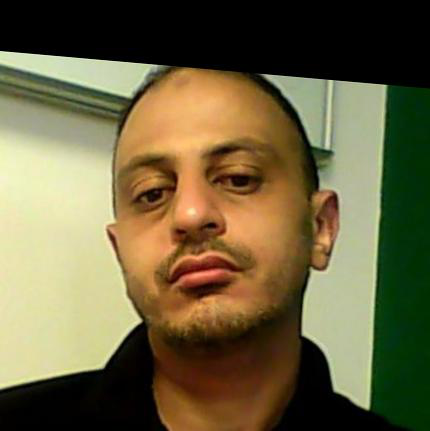

Printing image with dimensions 408x408


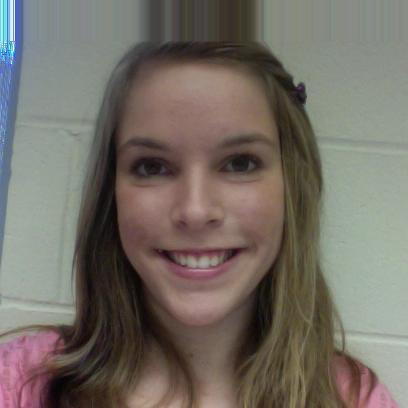

In [ ]:
path = '/datasets/faces/final_files'
images = os.listdir(path)
images = images[:15]
for image in images:
    if image.endswith('.jpg') or image.endswith('.png'):
        im = Image.open(path + '/' + image)
        width, height = im.size
        print('Printing image with dimensions {}x{}'.format(width, height))
        im.show()
    else:
        continue

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b>Комментарий ревьюера:</b>

✔️ Отлично, что выведены изображения.
</div>

- фотографии имеют разное разрешение, при обучении модели они бдут привидены к одному формату

## Обучение модели

- За основу модели взять сверточная модель архитектуры ResNet
- Загружены данные для тернировочной и валидационной выборок
- Подбор шага реализован автоматически алгоритом Adam
- Так как задача регресии и все исследуемые значения положительные, то будет использоваться активатия Relu
- Функцию потерь будем использовать MSE, так как она хорошо подходит для подобных задач регресии

**Код обучения модели:**

```python
import pandas as pd
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from keras.callbacks import EarlyStopping

def load_train(path):
  datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split=0.25,
                             horizontal_flip=True,
                             vertical_flip=True)
  train_datagen_flow = datagen.flow_from_dataframe(
      dataframe=pd.read_csv(f'{path}/labels.csv'),
      directory=f"{path}/final_files",
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),
      batch_size=32,
      class_mode='raw',
      subset='training',
      seed=12345)
  return train_datagen_flow

def load_test(path):
  datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split=0.25)
  val_datagen_flow = datagen.flow_from_dataframe(
      dataframe=pd.read_csv(f'{path}/labels.csv'),
      directory=f"{path}/final_files",
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),
      batch_size=32,
      class_mode='raw',
      subset='validation',
      seed=12345)
  return val_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001), metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

**Результат обучения модели:**

```

<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Train for 178 steps, validate for 60 steps
Epoch 1/5
178/178 - 65s - loss: 298.2937 - mae: 12.5491 - val_loss: 1057.5420 - val_mae: 27.9011
Epoch 2/5
178/178 - 40s - loss: 108.6858 - mae: 7.8827 - val_loss: 459.6920 - val_mae: 16.0555
Epoch 3/5
178/178 - 40s - loss: 81.9546 - mae: 6.8987 - val_loss: 246.2057 - val_mae: 11.7699
Epoch 4/5
178/178 - 39s - loss: 66.8348 - mae: 6.1418 - val_loss: 131.0221 - val_mae: 8.7873
Epoch 5/5
178/178 - 40s - loss: 52.6589 - mae: 5.5149 - val_loss: 98.8569 - val_mae: 7.5794

60/60 - 10s - loss: 98.8569 - mae: 7.5794
Test MAE: 7.5794

```

## Анализ обученной модели

**Выводы:**

В рамках данного проекта необходимо было построить модель, которая по фотографии определит приблизительный возраст человека.  В нашем распоряжении был набор фотографий людей с указанием возраста из файла `/datasets/faces/labels.csv`.

Перед началом обучения был проведен исследовательский анализ данных, который показал:

- датасет соответстует описанию проекта
- выборка небольшая (7591 изображений), рекомендуется для увелечиния выборки использовать аугментацию
- выборка несбалансированная, большье всего фотограий людей до 30 лет, модель наилучше будет справляться именно с этой возрастной группой
- нет пропусков в списке фотогрфий
- все фотографии имеют нужное расширение и могут использоваться в обучении модели
- фотографии имеют разное разрешение, при обучении модели они бдут привидены к одному формату

При обучении использовались следующие параметры:

- За основу модели взять сверточная модель архитектуры ResNet
- Загружены данные для тернировочной и валидационной выборок
- Подбор шага реализован автоматически алгоритом Adam
- Так как задача регресии и все исследуемые значения положительные, то будет использоваться активатия Relu
- Функцию потерь будем использовать MSE, так как она хорошо подходит для подобных задач регресии

Результаты модели показали хорошие результаты, качество метрики на тестовой выборке MAE= 7.5794, что соответствует ТЗ проекта (MAE<8). Данная модель рекомендуется к внедрению, для анализа покупок и предложения товаров, которые могут заинтересовать покупателей соответствующей возрастной группы.